In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install mlflow

In [6]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('geolocation.csv', 'geolocation'),
    ('order_items.csv', 'order_items'),
    ('orders.csv', 'orders'),
    ('payments.csv', 'payments'),
    ('products.csv', 'products'),
    ('sellers.csv', 'sellers'),
      # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='mysqlabs31.com',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'G:/Data Science Project/Ecommerce Python+SQL/Datasets'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered

In [8]:
pip install seaborn

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host = "localhost",
    username = "root",
    password = "mysqlabs31.com",
    database = "ecommerce"
)

cur = db.cursor()

# Basic Queries

## 1. List all unique cities where customers are located.

In [10]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

0
0                 franca
1  sao bernardo do campo
2              sao paulo
3        mogi das cruzes
4               campinas

## 2. Count the number of orders placed in 2017.

In [11]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total order placed in 2017 are", data[0][0]

('total order placed in 2017 are', 45101)

## 3. Find the total sales per category.

In [12]:
query = """ select upper(products.product_category), round(sum(payments.payment_value),2)
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by products.product_category; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["CATEGORY", "TOTAL_SALES"])
df.head()

CATEGORY  TOTAL_SALES
0             PERFUMERY    506738.66
1  FURNITURE DECORATION   1430176.39
2             TELEPHONY    486882.05
3        BED TABLE BATH   1712553.67
4            AUTOMOTIVE    852294.33

## 4. Calculate the percentage of orders that were paid in installments.

In [13]:
query = """ select (sum(case when payments.payment_installments >= 1 then 1 else 0 end)/count(*))*100 from payments; """

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments is", data[0]

('The percentage of orders that were paid in installments is',
 (Decimal('99.9981'),))

## 5. Count the number of customers from each state. 

In [14]:
query = """ select  customer_state, count(customer_id) from customers
group by customer_state
order by count(customer_id) desc; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["States", "Customer_Count"])
df.head()

States  Customer_Count
0     SP           41746
1     RJ           12852
2     MG           11635
3     RS            5466
4     PR            5045

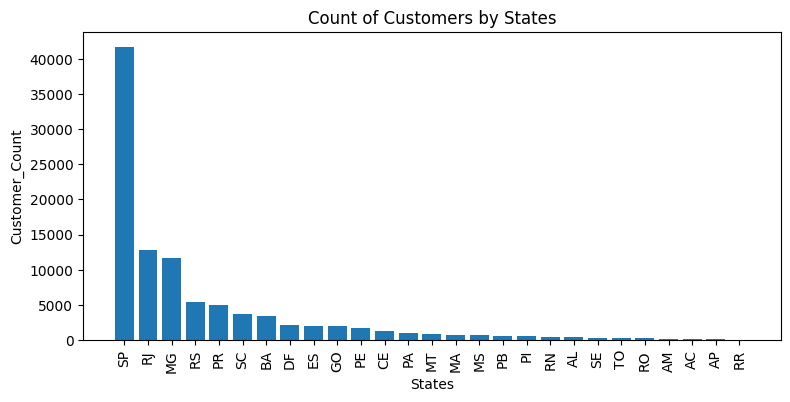

In [15]:
plt.figure(figsize = (9,4))
plt.bar(df["States"], df["Customer_Count"])
plt.xlabel("States")
plt.ylabel("Customer_Count")
plt.title("Count of Customers by States")
plt.xticks(rotation = 90)
plt.show()

## Intermediate Queries

### 1. Calculate the number of orders per month in 2018.

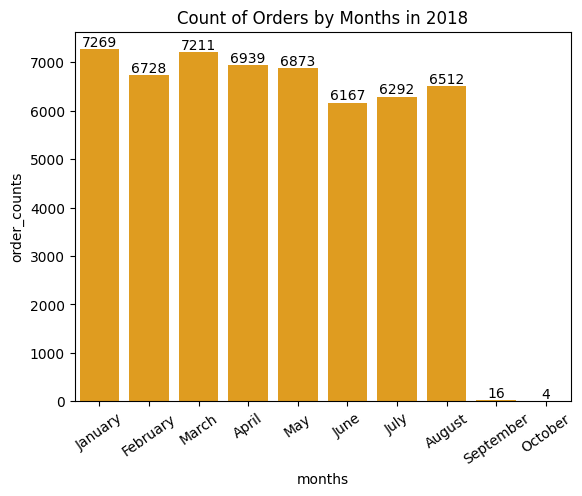

In [16]:
query = """ select monthname(order_purchase_timestamp) as months, count(order_id) as orders
from orders
where year(order_purchase_timestamp) = 2018
group by months; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["months", "order_counts"])

o = ["January", "February", "March", "April", "May","June", "July", "August", "September", "October"]

ax = sns.barplot(x = df["months"], y = df["order_counts"], data = df, order = o, color = "orange")
ax.bar_label(ax.containers[0])
plt.xticks(rotation=35)
plt.title("Count of Orders by Months in 2018")
plt.show()

### 2. Find the average number of products per order, grouped by customer city.

In [17]:
query = """ with count_per_order as (
select orders.order_id, orders.customer_id, count(order_items.order_item_id) as oc
from orders join order_items 
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id
)

select customers.customer_city, round(avg(count_per_order.oc),2) as average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Customers_city", "Average_orders"])

df.head(10)

Customers_city Average_orders
0      padre carvalho           7.00
1         celso ramos           6.50
2               datas           6.00
3       candido godoi           6.00
4      matias olimpio           5.00
5          cidelandia           4.00
6             picarra           4.00
7  morro de sao paulo           4.00
8     teixeira soares           4.00
9          curralinho           4.00

### 3. Calculate the percentage of total revenue contributed by each product category.

In [18]:
query = """ select upper(products.product_category) as Category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as Total_Sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by products.product_category
order by Total_Sales DESC; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Parcentage_Total_Revenue"])

df

Category  Parcentage_Total_Revenue
0                BED TABLE BATH                     10.70
1                 HEALTH BEAUTY                     10.35
2          COMPUTER ACCESSORIES                      9.90
3          FURNITURE DECORATION                      8.93
4               WATCHES PRESENT                      8.93
..                          ...                       ...
69              HOUSE COMFORT 2                      0.01
70               CDS MUSIC DVDS                      0.01
71                     PC GAMER                      0.01
72  FASHION CHILDREN'S CLOTHING                      0.00
73       INSURANCE AND SERVICES                      0.00

[74 rows x 2 columns]

### 4. Identify the correlation between product price and the number of times a product has been purchased.

In [19]:
query = """ select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Order_Count", "Price"])

arr1 = df["Order_Count"]
arr2 = df["Price"]

a = np.corrcoef([arr1, arr2])

print("The Correlation is", a[0][1])

The Correlation is -0.10631514167157562


### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [20]:
query = """ select *, dense_rank() over(order by revenue desc) as ranks from
(select order_items.seller_id, 
sum(payments.payment_value) as revenue
from payments join order_items
on payments.order_id = order_items.order_id
group by order_items.seller_id) as a; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Seller_ID", "Revenue", "Rank"])

df

Seller_ID        Revenue  Rank
0     7c67e1448b00f6e969d365cea6b010ab  507166.907302     1
1     1025f0e2d44d7041d6cf58b6550e0bfa  308222.039840     2
2     4a3ca9315b744ce9f8e9374361493884  301245.269765     3
3     1f50f920176fa81dab994f9023523100  290253.420128     4
4     53243585a1d6dc2643021fd1853d8905  284903.080498     5
...                                ...            ...   ...
3090  ad14615bdd492b01b0d97922e87cb87f      19.209999  3082
3091  702835e4b785b67a084280efca355756      18.559999  3083
3092  4965a7002cca77301c82d3f91b82e1a9      16.360001  3084
3093  77128dec4bec4878c37ab7d6169d6f26      15.220000  3085
3094  cf6f6bc4df3999b9c6440f124fb2f687      12.220000  3086

[3095 rows x 3 columns]

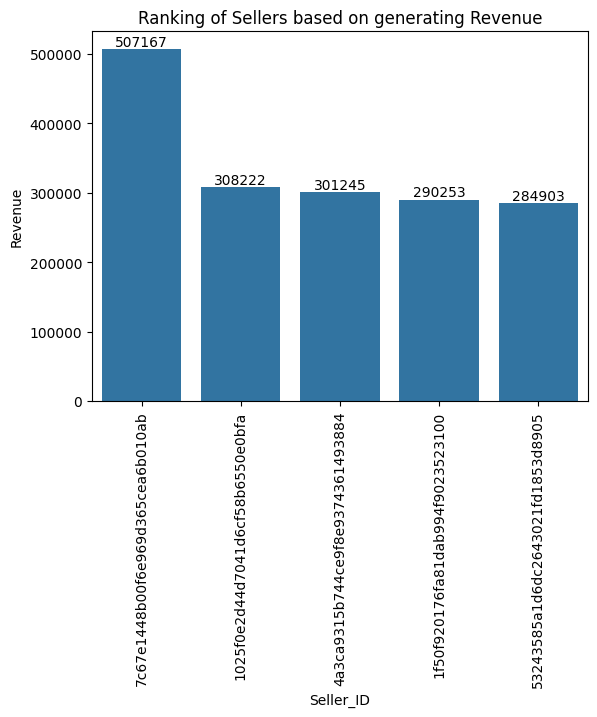

In [21]:
df = df.head(5)

ax = sns.barplot(x = df["Seller_ID"], y = df["Revenue"],data = df)

ax.bar_label(ax.containers[0])
plt.title("Ranking of Sellers based on generating Revenue")

plt.xticks(rotation = 90)
plt.show()

# Advanced Queries

## 1. Calculate the moving average of order values for each customer over their order history.

In [22]:
query = """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg
from
(select customers.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from customers join orders
on customers.customer_id = orders.customer_id
join payments
on payments.order_id = orders.order_id) as a; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Customer_ID", "Order_TimeStamp", "Price", "Moving_Avg"])
df.head()

Customer_ID      Order_TimeStamp   Price  Moving_Avg
0  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.74  114.739998
1  000161a058600d5901f007fab4c27140  2017-07-16 09:40:32   67.41   67.410004
2  0001fd6190edaaf884bcaf3d49edf079  2017-02-28 11:06:43  195.42  195.419998
3  0002414f95344307404f0ace7a26f1d5  2017-08-16 13:09:20  179.35  179.350006
4  000379cdec625522490c315e70c7a9fb  2018-04-02 13:42:17  107.01  107.010002

## 2. Calculate the cumulative sales per month for each year.

In [23]:
query = """ select years, months, payment,
sum(payment) over(order by years, months) as cumulative_sales
from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
sum(payments.payment_value) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years, months) as a; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Order_Year", "Order_Month", "Sales", "Cumulative_Sales"])
df.head(10)

Order_Year  Order_Month          Sales  Cumulative_Sales
0        2016            9     252.239994      2.522400e+02
1        2016           10   59090.479999      5.934272e+04
2        2016           12      19.620001      5.936234e+04
3        2017            1  138488.040064      1.978504e+05
4        2017            2  291908.009507      4.897584e+05
5        2017            3  449863.599528      9.396220e+05
6        2017            4  417788.029499      1.357410e+06
7        2017            5  592918.820136      1.950329e+06
8        2017            6  511276.380329      2.461605e+06
9        2017            7  592382.919487      3.053988e+06

## 3. Calculate the year-over-year growth rate of total sales.

In [24]:
query = """ with a as 
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years)

select years, payment, lag(payment, 1) over(order by years) as previous_year, 
round(((payment - lag(payment, 1) over(order by years)) / (lag(payment, 1) over(order by years)) * 100),3) as yoy_growth
from a; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Order_Year", "Current_Year_Sales", "Previous_Year_Sales", "YoY%Growth"])
df

Order_Year  Current_Year_Sales  Previous_Year_Sales  YoY%Growth
0        2016            59362.34                  NaN         NaN
1        2017          7249746.73             59362.34   12112.704
2        2018          8699763.05           7249746.73      20.001

## 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [25]:
query = """ with a as
(select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) as next_order
from a join orders
on a.customer_id = orders.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/(count(distinct b.customer_id)))
from a left join b
on a.customer_id = b.customer_id; """

cur.execute(query)

data = cur.fetchall()

print("Since non of our customers are repeated thats why our value is",data)

Since non of our customers are repeated thats why our value is [(None,)]


## 5. Identify the top 3 customers who spent the most money in each year.

In [26]:
query = """ select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) as years,
orders.customer_id,
round(sum(payments.payment_value),3) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc)
as d_rank
from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <=3; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Year", "Customer_ID", "Payment", "Rank"])
df

Year                       Customer_ID   Payment  Rank
0  2016  a9dc96b027d1252bbac0a9b72d837fc6   1423.55     1
1  2016  1d34ed25963d5aae4cf3d7f3a4cda173   1400.74     2
2  2016  4a06381959b6670756de02e07b83815f   1227.78     3
3  2017  1617b1357756262bfa56ab541c47bc16  13664.08     1
4  2017  c6e2731c5b391845f6800c97401a43a9   6929.31     2
5  2017  3fd6777bbce08a352fddd04e4a7cc8f6   6726.66     3
6  2018  ec5b2ba62e574342386871631fafd3fc   7274.88     1
7  2018  f48d464a0baaea338cb25f816991ab1f   6922.21     2
8  2018  e0a2412720e9ea4f26c1ac985f6a7358   4809.44     3

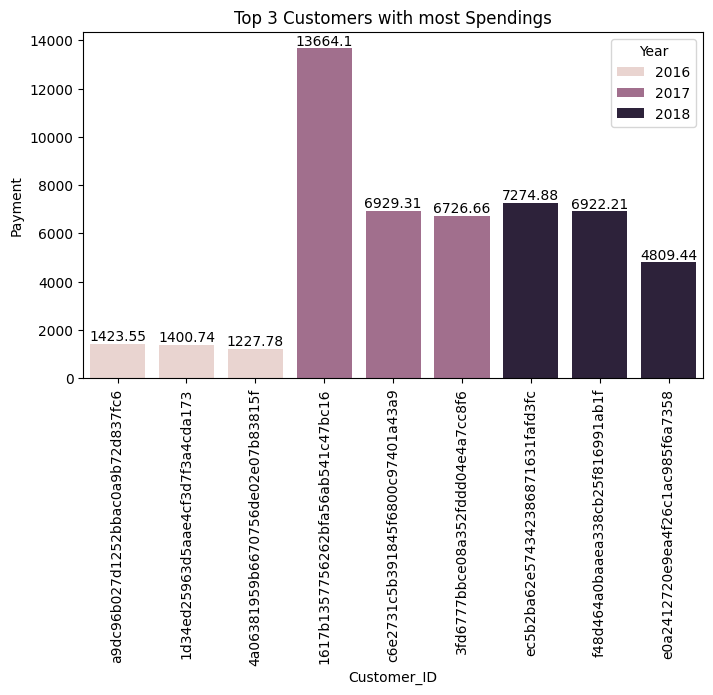

In [27]:
plt.figure(figsize=(8,4.5))
ax = sns.barplot(x = "Customer_ID", y = "Payment", data = df, hue = "Year")

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])

plt.title("Top 3 Customers with most Spendings")
plt.xticks(rotation = 90)
plt.show()